# Pip Installs

In [1]:
%%capture

!pip install librosa
!pip install tensorflow
!pip install numpy==1.23.5
!pip install pysoundfile

Tensor flow does not work with Numpy 2.0 onward so make sure that 

# Imports

Below are the necessary imports 

In [2]:
#Imports
from pydub import AudioSegment as audio
import os
import numpy as np
import librosa
#Tensor Flow needs numpy at 1.23.5
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import re 
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# File Creation

### Creating File Paths

In [44]:
unprocessed_data_dir = os.path.abspath('') + "/Unprocessed_Wav_Files"
proccesed_data_dir = os.path.abspath('') + "/Processed_Wav_Files"

Steps
- go through all files in the unprocessed wav files
- break up all files so they are split by 1 second
- use regex to get the file name minus the .wav at the end to make new 1 second wav files
- save each of the files into the processed wav folder

Resample the unproccessed audio files for speaker recognition. This is needed for tensorflow and keras

In [4]:
#This was a test for the fixing the audio with a single thing

"""
f_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
new_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)
sf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)
"""


'\nf_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")\narr, hz = librosa.load(f_path, sr = None)\nnew_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)\nsf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)\n'

### Changes the Unporcessed_Wav_Files into 16000 hz

This is necessary for speaker recognition model training and feature extractions

In [45]:
for file in os.listdir(unprocessed_data_dir):
    f_path = os.path.join(unprocessed_data_dir, file)
    arr, hz = librosa.load(f_path,sr = None)
    if hz != 16000:
        new_f = librosa.resample(arr, orig_sr = hz, target_sr = 16000)
        sf.write(f_path, new_f, 16000)

This is a test

In [46]:
f_path = os.path.join(unprocessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
print(hz)

16000


### Separates the files into 1 second intervals

In [48]:
for filename in os.listdir(unprocessed_data_dir):
    if filename.endswith(".wav"):
        hearing = audio.from_wav(os.path.join(unprocessed_data_dir,filename))
        speaker = filename.removesuffix(".wav")
        #name of congress person for processed_wav_files folder
        congress_name = speaker[:re.search(r"\d+",speaker).start()] 
        #start duration in milliseconds for audio recording start
        t1 = 0
        #end duration in milliseconds for audio recording start
        t2 = 1000
        #second of the clip
        second = 1
        total_time = hearing.duration_seconds*1000
        # Goes through all of the large audio files, splits them into 1 second audio files
        # and saves to the speaker name folder
        while t2 <= total_time:
            new_audio = hearing[t1:t2]
            #arr, hz = librosa.load(new_audio, sr = None)
            try:
                os.makedirs(f"{proccesed_data_dir}/{congress_name}")
                new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
            except:
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
                new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
            t1 += 1000
            t2 += 1000
            second += 1

Check the Hz of a split file

In [49]:
a,b = librosa.load(os.path.abspath('')  + "/Processed_Wav_Files/addisonWilson/addisonWilson40173Clip1_2.wav", sr = None)
print(b)

16000


### Feature Extraction

In [50]:
def feature_extract (data_dir):
    features = []
    labels = []
    for foldr in os.listdir(data_dir):
        if foldr != ".DS_Store":
            for file in os.listdir(f"{data_dir}/{foldr}"):
                arr, hz = librosa.load(os.path.join(data_dir,foldr,file), sr = None, duration =  1)
                mfccs = librosa.feature.mfcc(y = arr, sr = hz, n_mfcc = 13)
                mfccs = StandardScaler().fit_transform(mfccs)
                features.append(mfccs.T)
                labels.append(foldr)       
    return np.array(features), np.array(labels)           
features, labels = feature_extract(proccesed_data_dir)

### Feature Visualization

In [51]:
for feature_set, label in zip(features, labels[74:150]):
    print(f"Label: {label}, Features Shape: {feature_set.shape}")
    print(feature_set[0])  # Optionally print the actual features
    print("-" * 40)  # Separator for readability

Label: jamesJordan, Features Shape: (32, 13)
[-3.360361   -0.1903183   0.77904576  0.15367031  0.22454423  0.7346955
  0.19315235  0.37246782  0.30784097  0.07275002  0.29632047  0.19204979
  0.22414224]
----------------------------------------
Label: jamesJordan, Features Shape: (32, 13)
[-3.004173    1.3296394  -0.24910702  1.3453428   0.13564226 -0.1008335
  0.27885127  0.10520647  0.15796548 -0.3386022   0.19895187  0.18986304
 -0.04874685]
----------------------------------------
Label: jamesJordan, Features Shape: (32, 13)
[-3.0829401e+00  1.5331542e+00  1.5818969e-04  9.0373278e-01
  2.7616814e-01 -1.6860381e-01  1.2954178e-01  5.0936118e-02
  3.0296618e-01 -2.4682966e-01  1.3251595e-01  1.8341005e-01
 -1.4209974e-02]
----------------------------------------
Label: jamesJordan, Features Shape: (32, 13)
[-3.2771137   0.8414707   0.16856258  1.0565054   0.38853514  0.03541012
  0.28715527  0.11213993  0.25858703 -0.12735942 -0.05219261  0.27088258
  0.03741675]
-------------------

### Training and splitting the data

In [52]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= .2, random_state= 42)

In [53]:
#Original shape shows n_samples, n_features, and n_channels
print(X_train.shape)

(3102, 32, 13)


### Reshape for SVM since it takes 2D arrays

In [54]:
X_train_SVM = X_train.reshape(X_train.shape[0], -1)
X_test_SVM = X_test.reshape(X_test.shape[0], -1)

### Trying the SVM approach

In [55]:
clm = SVC(kernel="linear")
clm.fit(X_train_SVM,y_train)

y_predict = clm.predict(X_test_SVM)
incorrect = y_predict != y_test
print((len(y_test) - sum(incorrect))/len(y_test))

0.7435567010309279


In [56]:
total = 0
predict = 0
real_dict = {}
pred_dict = {}

for i in labels:
    real_dict[i] = 0
    pred_dict[i] = 0

for pred, real in zip(y_predict,y_test):
    real_dict[real] += 1
    pred_dict[real] += 1 if real == pred else 0
for name in real_dict:
    print(
         f"{name} \n\taccuracy = {pred_dict[name]/real_dict[name]}" 
         f"\n\tpredict/real = {pred_dict[name]}/{real_dict[name]}"
         )

jamesJordan 
	accuracy = 0.7058823529411765
	predict/real = 48/68
kevinKiley 
	accuracy = 0.717391304347826
	predict/real = 33/46
victoriaSpartz 
	accuracy = 0.76
	predict/real = 19/25
richardLarsen 
	accuracy = 0.8409090909090909
	predict/real = 37/44
samuelGraves 
	accuracy = 0.5945945945945946
	predict/real = 44/74
christineSmith 
	accuracy = 0.6
	predict/real = 6/10
michaelQuigley 
	accuracy = 0.6666666666666666
	predict/real = 6/9
addisonWilson 
	accuracy = 0.9238578680203046
	predict/real = 182/197
jerroldNadler 
	accuracy = 0.8133333333333334
	predict/real = 61/75
michaelLawler 
	accuracy = 0.4666666666666667
	predict/real = 7/15
stephenCohen 
	accuracy = 0.6845637583892618
	predict/real = 102/149
thomasMcclintock 
	accuracy = 0.5
	predict/real = 24/48
sheldonWhitehouse 
	accuracy = 0.5
	predict/real = 8/16


## Try RNN approach

### Label Encoding

In [57]:
label_encoder = LabelEncoder()
label_enc = label_encoder.fit_transform(labels)
#label_encoder.classes_ = np.array(labels)
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(features, label_enc, test_size=0.2, random_state=42)
print(len(np.unique(label_enc)))
print(len(np.unique(y_train_rnn)))

13
13


In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(label_enc)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
history = model.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=32)

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.2807 - loss: 2.1929
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.4948 - loss: 1.5482
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6379 - loss: 1.1291
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6713 - loss: 0.9966
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7335 - loss: 0.8128
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7410 - loss: 0.8003
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7747 - loss: 0.6786
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7795 - loss: 0.6486
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8006 - loss: 0.6062
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8284 - loss: 0.5123
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8156 - loss: 0.5230
Epoch 12/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy:

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
Prediction time: 2.1749629974365234
776
Test Evaluation Accuracy: 0.8556701030927835


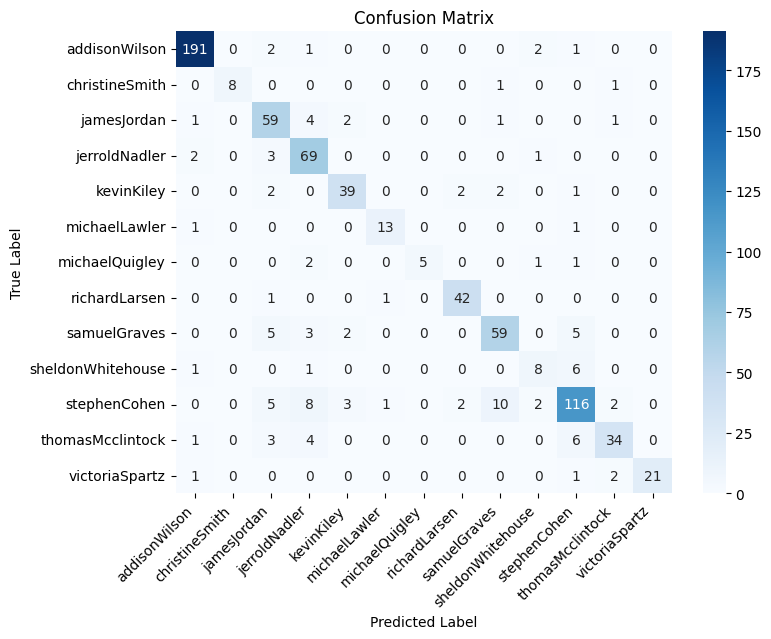

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
start_time = time.time()
y_pred_probabilities = model.predict(X_test_rnn)
print("Prediction time:", time.time() - start_time)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print(len(y_pred_decoded))
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()